# Deep Learning Classification of fdom Anomaly Peaks with Resnet
Using k-fold validation

In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing
from Deep_Learning.resnet import ResNet1D
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from Deep_Learning.datasets import fdomDataset, collate_fn_pad
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
)
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from functools import partial


In [2]:
# util functions
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            print(f"reset trainable params of layer = {layer}")
            layer.reset_parameters()


## Hyperparameters
Adjust as needed!

In [3]:
# Hyperparams
WINDOW_SIZE = 15  # the size of each data segment
SEED = 42
BATCH_SIZE = 32

# this is the number of epochs per fold, but because data is already batched,
#   when larger than 1, training takes a long time
EPOCHS = 1

SPLITS = 5


In [4]:
# Paths to data files
fdom_raw_data = (
    "Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
)
stage_raw_data = "Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = (
    "Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)
fdom_labeled = "Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"

# augmented files
fdom_raw_augmented = "Data/augmented_data/fdom/unlabeled/unlabeled_fdom.csv"
fdom_labeled_augmented = "Data/augmented_data/fdom/labeled/labeled_fdom_peaks.csv"
turb_augmented_raw_data = "Data/augmented_data/fdom/unlabeled/unlabeled_turb.csv"
stage_augmented_data_fn = "Data/augmented_data/fdom/unlabeled/unlabeled_stage.csv"

In [5]:
# get device (cpu or cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Create Dataset
Use the custom dataset class to setup the dataset, classes, and targets

In [6]:
# list of classnames
classes = ["NAP", "FSK", "FPT", "PLP", "PP", "SKP"]

# create label encoder, encode classes into integers
le = preprocessing.LabelEncoder()
targets = le.fit_transform(classes)

# create dataset
dataset = fdomDataset(
    le,
    fdom_raw_data,
    stage_raw_data,
    turb_raw_data,
    fdom_labeled,
    fdom_raw_augmented,
    stage_augmented_data_fn,
    turb_augmented_raw_data,
    fdom_labeled_augmented,
)

/Users/claykaufmann/Projects/srrw-anomaly-detection/Tools/get_candidates.py:221: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(
/Users/claykaufmann/Projects/srrw-anomaly-detection/Tools/get_candidates.py:385: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(


5400 candidates found.


## Setup KFold cross validation

In [7]:
torch.manual_seed(42)
results = {}

tss = TimeSeriesSplit(SPLITS)

criterion = nn.CrossEntropyLoss().to(device)

## Training
Train the model, and print out simple accuracy results.

In [8]:
# K-fold training
conf_matrices = {}
accumulated_metrics = {}

for fold, (train_ids, test_ids) in enumerate(tss.split(dataset)):
    print(f"FOLD {fold}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler,
        collate_fn=partial(collate_fn_pad, device=device),
    )

    testloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=test_subsampler,
        collate_fn=partial(collate_fn_pad, device=device),
    )

    # init model
    model = ResNet1D(
        in_channels=4,
        base_filters=64,
        kernel_size=16,
        stride=2,
        n_block=48,
        groups=1,  # check this
        n_classes=len(classes),
        downsample_gap=6,
        increasefilter_gap=12,
        verbose=False,
    ).to(device)

    # set model to use float instead of doubles to prevent errors
    model = model.float()

    # init optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(0, EPOCHS):
        print(f"Starting epoch {epoch + 1}")

        current_loss = 0

        # prog bar
        prog_bar = tqdm(trainloader, desc="Training", leave=False)
        for i, data in enumerate(prog_bar):
            x = data[0].to(device)
            y = data[1].squeeze().to(device)

            optimizer.zero_grad()

            pred = model(x.float())
            loss = criterion(pred, y)

            loss.backward()
            optimizer.step()

            # print stats
            current_loss += loss.item()
            if i % 500 == 499:
                print("Loss after mini-batch %5d: %.3f" % (i + 1, current_loss / 500))
                current_loss = 0.0

    # completed training, now test
    print(f"Training for fold {fold} has completed, now testing")

    # save best params
    save_path = f"./results/models/fdom/model-fold={fold}.pth"
    torch.save(model.state_dict(), save_path)

    total, correct = 0, 0

    # for checking correct and incorrect preds
    y_true = []
    y_pred = []

    prog_bar = tqdm(testloader, desc="Testing", leave=False)
    with torch.no_grad():
        for i, data in enumerate(prog_bar):
            x = data[0].to(device)
            y = data[1].squeeze().to(device)

            outputs = model(x.float())

            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(y, preds):
                # convert label and prediction to current vals
                label = le.inverse_transform([label])[0]
                prediction = le.inverse_transform([prediction])[0]

                # for confusion matrices
                y_pred.append(prediction)
                y_true.append(label)

                if label == prediction:
                    correct += 1
                total += 1

        # Print rough general accuracy
        print("Accuracy for fold %d: %d %%" % (fold, 100.0 * correct / total))
        print("--------------------------------")
        results[fold] = 100.0 * (correct / total)

        # make classification report
        acc_report = classification_report(y_true, y_pred)
        print(acc_report)

        # get acc score
        acc_score = accuracy_score(y_true, y_pred)

        bal_acc = balanced_accuracy_score(y_true, y_pred)

        f1 = f1_score(
            y_true,
            y_pred,
            average="weighted",
        )

        precision = precision_score(
            y_true,
            y_pred,
            average="weighted",
        )

        # make conf matrix
        matrix = confusion_matrix(y_true, y_pred, labels=classes)

        # save conf matrix
        conf_matrices[fold] = copy.deepcopy(matrix)

        # save accumulated metrics
        accumulated_metrics[fold] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

# Print fold results
print("\n")
print(f"K-FOLD CROSS VALIDATION RESULTS FOR {SPLITS} FOLDS")
print("--------------------------------")
sum = 0.0
for key, value in results.items():
    print(f"Fold {key}: {value} %")
    sum += value
print(f"Average: {sum/len(results.items())} %")


FOLD 0
Starting epoch 1


Training:   0%|          | 0/29 [00:00<?, ?it/s]/Users/claykaufmann/Projects/srrw-anomaly-detection/Deep_Learning/datasets.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804309932/work/torch/csrc/utils/tensor_new.cpp:210.)
  label_list = torch.tensor(label_list, dtype=torch.int64)


KeyboardInterrupt: 

Mean Test F1:  0.41622800947672794
Mean Test BA:  0.24
Mean Test Acc:  0.5191806331471136
Mean Test Precision:  0.38168596485752626


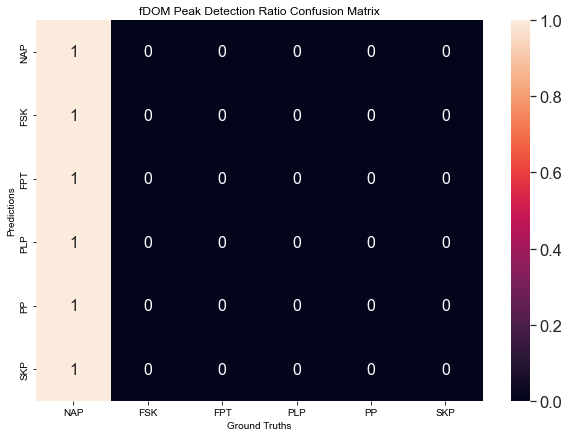

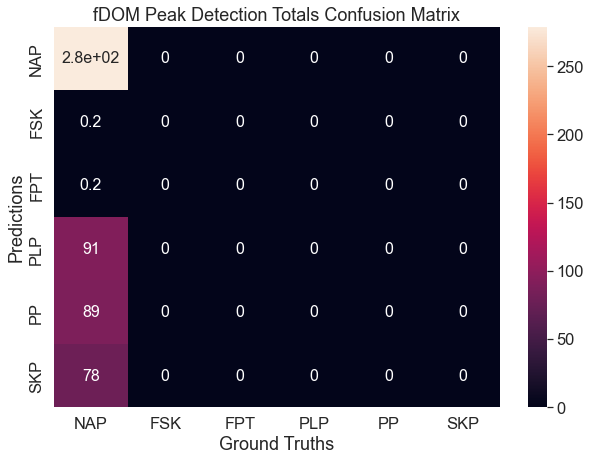

In [ ]:
# save accumulated metrics
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_metrics:
    metrics = accumulated_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_metrics))

# make mean confusion matrix
mean_cfmx = np.zeros((len(classes), len(classes)))
for key in conf_matrices.keys():
    mean_cfmx += conf_matrices[key]

mean_cfmx = mean_cfmx / len(conf_matrices)

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Ratio Confusion Matrix")

sn.set(font_scale=1.5)

sn.heatmap(
    pd.DataFrame(
        mean_cfmx.astype("float") / mean_cfmx.sum(axis=1)[:, np.newaxis],
        index=classes,
        columns=classes,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Totals Confusion Matrix")

sn.set(font_scale=1.5)

sn.heatmap(
    pd.DataFrame(
        mean_cfmx,
        index=classes,
        columns=classes,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()

In [ ]:
# save plots and metrics
